In [22]:
from tensorflow.keras.models import load_model
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

loaded_model = load_model('saved_models/NVspin_GRU_model_Rho.h5')

2023-11-17 13:38:35.308609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-17 13:38:35.309753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-17 13:38:35.310596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [23]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


#########################################################################

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)


#########################################################################

init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


def fidelity(target_rho):
    
    predicted_sequence = loaded_model.predict([target_rho])

    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)

    Uni = s0
    U_0 = unitary(dt, 0)
    U_1 = unitary(dt, 1)
    U_2 = unitary(dt, 2)
    U_3 = unitary(dt, 3)
    U_4 = unitary(dt, 4)
    
    pulse_list = [U_0, U_1, U_2, U_3, U_4]
    
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,target_rho))
    
    return  F

In [24]:
from math import *

def hermitian_matrix_to_vector(matrix):
    # 행렬의 크기를 가져옴
    n = matrix.shape[0]

    # 에르미트 행렬인지 확인
    assert np.allclose(matrix, matrix.conj().T)

    # 상삼각 행렬의 원소를 가져와 벡터로 변환
    vector = np.zeros((n * (n + 1)) // 2, dtype=complex)
    idx = 0
    for i in range(n):
        for j in range(i + 1):
            vector[idx] = matrix[i, j]
            idx += 1

    return vector

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])
    
# Initial state
init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave, init_wave.conj().T)

def making_rho(theta, phi):

    # Target state
    # Theta must move first and then phi move.
    target_U = Rz(theta) @ Rx(phi) 
    irho_target = target_U @ irho_init @ target_U.conj().T
    
    # matrix to vector
    irho_target = hermitian_matrix_to_vector(irho_target)
    
    return irho_target


In [25]:
sum = 0
iter = 10000
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

for i in range(iter) :     
     
     target_theta = np.pi / 180 * random.uniform(0,180)
     target_phi = np.pi / 180 * random.uniform(0,360)
     
     target_rho = making_rho(target_theta, target_phi)
     
     temp = fidelity(target_rho)
     fidelities.append(temp)
     
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     
     sum += temp

print(sum/iter)

ValueError: in user code:

    File "/home/yeojung/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/yeojung/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/yeojung/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/yeojung/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/yeojung/.conda/envs/tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/yeojung/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_8' (type Functional).
    
    Input 0 of layer "repeat_vector_11" is incompatible with the layer: expected ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'model_8' (type Functional):
      • inputs=('tf.Tensor(shape=(None,), dtype=complex128)',)
      • training=False
      • mask=None


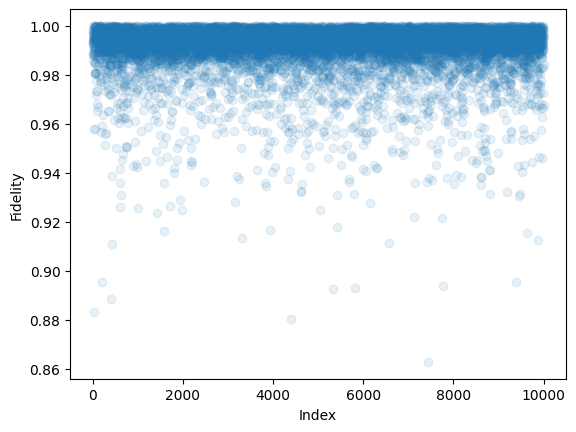

In [ ]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.1)
plt.xlabel('Index')
plt.ylabel('Fidelity')
plt.show()

In [ ]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

2 0.9882938697859813
7 0.9885215122894742
9 0.9890667711881412
12 0.9859621913971608
20 0.9878434589400078
22 0.8831012883122958
23 0.9578093512825251
25 0.9896490484986197
28 0.9850423784455344
35 0.9890444032566559
42 0.9808783813750205
43 0.9580858191573199
44 0.9847799976830293
45 0.9808929168001872
54 0.9878658849003539
57 0.9851071696664342
58 0.9805098075530154
59 0.9808296332590399
60 0.9891242542891195
68 0.9806576936131097
72 0.9733881615581266
74 0.9892127772610806
76 0.9840298794218666
78 0.977369867666012
79 0.9867890981323258
84 0.9716356752917938
94 0.9893916838802101
98 0.9653119290749991
103 0.9681820909801615
106 0.9734364868313288
107 0.9878105316313424
110 0.9870987027275191
111 0.9837609657324234
115 0.9876814618082108
124 0.9808374939044792
129 0.9667979227975847
130 0.9899996055012137
132 0.9894152221879453
134 0.9794985060759495
148 0.9848035297038233
149 0.9891936366982819
150 0.9888741844713448
151 0.9884372765766466
156 0.9865000501338836
158 0.98209335449107

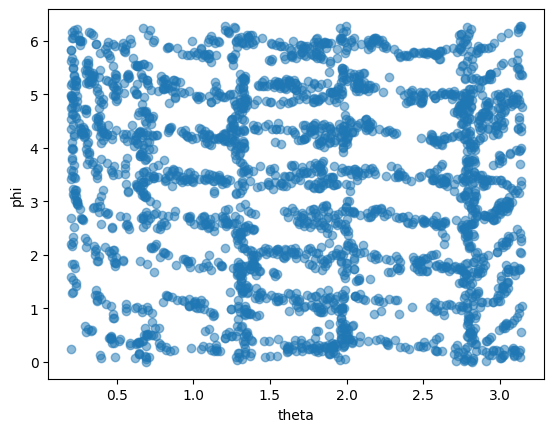

In [ ]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

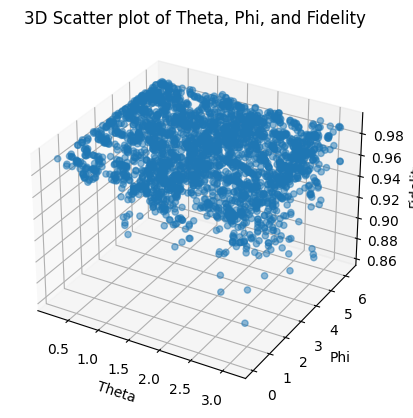

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(low_fidelities['theta'], low_fidelities['phi'], low_fidelities['fidelity'], alpha=0.5)
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_zlabel('Fidelity')
plt.title('3D Scatter plot of Theta, Phi, and Fidelity')
plt.show()


In [ ]:
# 피델리티 몇개 확인 99.99

optimal_fid = []

for i in fidelities:
     if i > 0.9999:
          optimal_fid.append(i)

# print(optimal_fid)
print(len(optimal_fid))
print(len(fidelities))
print(len(low_fidelities))

135
10000
3
